# Convolutional Neural Network

Instead of using Feed-Forward Neural Networks as in the previous assignment, this exercise aims to implement a Convolutional Neural Network (CNN), for solving two image classification problems: [German Traffic Sign Recognition Benchmark](https://benchmark.ini.rub.de/gtsrb_news.html) and [Cifar-100](https://web.stanford.edu/~hastie/CASI_files/DATA/cifar-100.html).

## Implementation

The base implementation in Python with the tensorflow library is given and the aim is to decide on the following factors:

- Architecture of your net.
- Optimization parameters and algorithms to train the net.
- Performance improvement (regularization, data augmentation, etc.)

For the [German Traffic Sign Recognition Benchmark](https://benchmark.ini.rub.de/gtsrb_news.html), multiple classic CNN architectures were tested, including LeNet, AlexNet and VGG-16 pre-trained. On the other side, a custom architecture was used for classifying the [Cifar-100](https://web.stanford.edu/~hastie/CASI_files/DATA/cifar-100.html) dataset.

## Results

The best performance found for the [German Traffic Sign Recognition Benchmark](https://benchmark.ini.rub.de/gtsrb_news.html) was using the model AlexNet without any pretraining, with little difference compared to the VGG-16. The validation accuracy was of 95.56\%.

The custom architecture developed for the [Cifar-100](https://web.stanford.edu/~hastie/CASI_files/DATA/cifar-100.html) achieved a 50.08\% of validation accuracy, much better than in previous assignment with 27.88\%.

## Authors

- Student Name 1: Stefano Baggetto
- Student Name 2: Giorgio Segalla
- Student Name 3: Angel Igareta ([angel@igareta.com](angel@igareta.com))


## Imports

In [ ]:
import os
import cv2

%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from time import time
from sklearn.utils import shuffle

from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
print(tf.__version__)

2.1.0


## German Traffic Sign Benchmark

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [ ]:
!wget http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2020-03-09 22:06:24--  http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
Resolving www.dia.fi.upm.es (www.dia.fi.upm.es)... 138.100.11.29
Connecting to www.dia.fi.upm.es (www.dia.fi.upm.es)|138.100.11.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip.1’

FullIJCNN2013.zip.1 100%[===================>]   1.55G  9.86MB/s    in 2m 50s  

2020-03-09 22:09:14 (9.30 MB/s) - ‘FullIJCNN2013.zip.1’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
replace FullIJCNN2013/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [ ]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

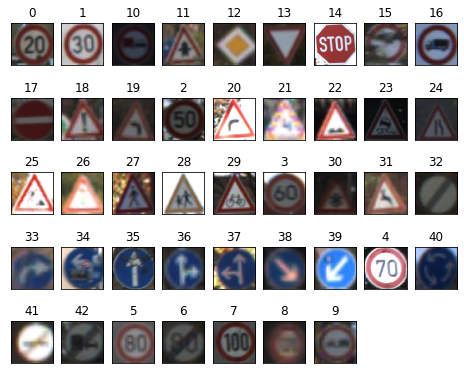

In [ ]:
# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

### Model

In [ ]:
batch_size_model_1 = 40
batch_size_model_2 = 100

epochs_model_1 = 70
epochs_model_2 = 48

# optimizer_model_1 = optimizers.Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999)
optimizer_model_1 = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer_model_2 = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

num_classes_1 = 43
num_classes_2 = 100

# train_steps = int(len(tr_signs) / batch_size_model_1)
# valid_steps = int(len(va_signs) / batch_size_model_1)

In [ ]:
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# def get_best_model():
#   base_model = ResNet50V2(input_shape=input_shape, weights='imagenet', include_top=False)

#   model = Flatten(input_shape=base_model.output.shape)(base_model.output)
#   model = Dense(1024, activation='sigmoid')(model)
#   predictions = Dense(num_classes, activation='softmax', name='pred')(model)

#   model = Model(inputs=[base_model.input], outputs=[predictions])

def get_lenet_model(input_shape, num_classes):
  model = keras.Sequential()

  model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(AveragePooling2D())

  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(AveragePooling2D())

  model.add(Flatten())

  model.add(Dense(units=120, activation='relu'))

  model.add(Dense(units=84, activation='relu'))

  model.add(Dense(units=num_classes, activation = 'softmax'))

  return model

from tensorflow.keras.applications.vgg16 import VGG16
def get_vgg16_model(input_shape, num_classes):
  base_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

  model = Flatten(input_shape=base_model.output.shape)(base_model.output)
  model = Dense(1024, activation='sigmoid')(model)
  predictions = Dense(num_classes, activation='softmax', name='pred')(model)

  model = Model(inputs=[base_model.input], outputs=[predictions])

  return model

def get_alexnet_model(input_shape, num_classes):
  model = Sequential()
  model.add(Conv2D(64, (11, 11), padding='valid', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Conv2D(128, (7, 7), padding='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Conv2D(192, (3, 3), padding='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Flatten())
  model.add(Dense(4096))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(4096))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(num_classes))
  model.add(BatchNormalization())
  model.add(Activation('softmax'))

  return model

def get_model(input_shape, num_classes):
  model = Sequential()
  model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Conv2D(128, (7, 7), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Conv2D(192, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Flatten())
  model.add(Dense(4096))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(4096))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(num_classes))
  model.add(BatchNormalization())
  model.add(Activation('softmax'))

  return model

def get_model_2(input_shape, num_classes):
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))
  model.add(Activation('elu'))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('elu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(Activation('elu'))

  model.add(Conv2D(256, (3, 3)))
  model.add(Activation('elu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(Activation('elu'))

  model.add(Conv2D(512, (3, 3)))
  model.add(Activation('elu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(1024))
  model.add(Activation('elu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  return model

In [ ]:
def visualize_accuracy(data):
  # Visualize model
  plt.plot(data.history['accuracy'])
  plt.plot(data.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def visualize_loss(data): 
  plt.plot(data.history['loss'])
  plt.plot(data.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

### Compile Model

### (Optional) Activate TPU
Note that fit_generator will not work

In [ ]:
# This address identifies the TPU we'll use when configuring TensorFlow.
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver) 

KeyError: ignored

### Evaluate Model without preprocessing

In [ ]:
with strategy.scope():
  model_1 = get_model(input_shape = (SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = num_classes_1)
  model_1.compile(loss='categorical_crossentropy', 
                optimizer=optimizer_model_1, 
                metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 214, 214, 64)      23296     
_________________________________________________________________
batch_normalization (BatchNo (None, 214, 214, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 214, 214, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 128)       401536    
_________________________________________________________________
batch_normalization_1 (Batch (None, 65, 65, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 65, 65, 128)       0

In [ ]:
data_1 = model_1.fit(tr_signs, tr_labels,
        batch_size=batch_size_model_1,
        epochs=epochs_model_1,
        verbose=2,
        validation_data=(va_signs, va_labels))

Train on 600 samples, validate on 252 samples
Epoch 1/400


FailedPreconditionError: ignored

361/361 [==============================] - 1s 4ms/sample - loss: 0.2232 - accuracy: 0.9418
CNN took 2.670315742492676 seconds
Test loss: 0.22315390824941386 - Accuracy: 0.94182825


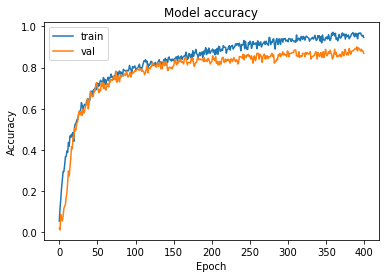

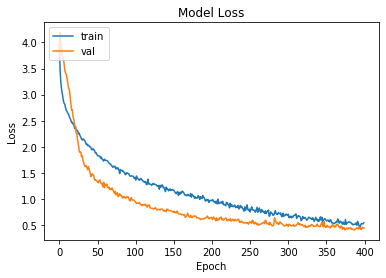

In [ ]:
start = time()
loss, acc = model_1.evaluate(te_signs, te_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

visualize_accuracy(data_1)
visualize_loss(data_1)

### Lenet


In [ ]:
with strategy.scope():
  lenet_model_1 = get_lenet_model(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = num_classes_1)
  lenet_model_1.compile(loss='categorical_crossentropy', 
                optimizer=optimizer_model_1, 
                metrics=['accuracy'])
lenet_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 6)       168       
_________________________________________________________________
average_pooling2d_2 (Average (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 16)      880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 46656)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               5598840   
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [ ]:
lenet_data_1 = lenet_model_1.fit(tr_signs, tr_labels,
        batch_size=batch_size_model_1,
        epochs=epochs_model_1,
        verbose=2,
        validation_data=(va_signs, va_labels))

Train on 600 samples, validate on 252 samples
Epoch 1/70
600/600 - 11s - loss: 3.7053 - accuracy: 0.0450 - val_loss: 3.6045 - val_accuracy: 0.0714
Epoch 2/70
600/600 - 1s - loss: 3.5368 - accuracy: 0.0983 - val_loss: 3.5022 - val_accuracy: 0.1111
Epoch 3/70
600/600 - 1s - loss: 3.3927 - accuracy: 0.1317 - val_loss: 3.3050 - val_accuracy: 0.1706
Epoch 4/70
600/600 - 1s - loss: 3.2049 - accuracy: 0.1900 - val_loss: 3.1567 - val_accuracy: 0.3016
Epoch 5/70
600/600 - 1s - loss: 3.0230 - accuracy: 0.2967 - val_loss: 2.9705 - val_accuracy: 0.2976
Epoch 6/70
600/600 - 1s - loss: 2.7560 - accuracy: 0.3733 - val_loss: 2.7159 - val_accuracy: 0.3611
Epoch 7/70
600/600 - 1s - loss: 2.3892 - accuracy: 0.4367 - val_loss: 2.6106 - val_accuracy: 0.4048
Epoch 8/70
600/600 - 1s - loss: 2.1676 - accuracy: 0.4900 - val_loss: 2.5900 - val_accuracy: 0.3889
Epoch 9/70
600/600 - 1s - loss: 1.9238 - accuracy: 0.5450 - val_loss: 2.1967 - val_accuracy: 0.5000
Epoch 10/70
600/600 - 1s - loss: 1.7095 - accuracy: 0

In [ ]:
start = time()
loss, acc = lenet_model_1.evaluate(te_signs, te_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

361/361 [==============================] - 1s 4ms/sample - loss: 1.1592 - accuracy: 0.8560
CNN took 2.7298872470855713 seconds
Test loss: 1.1591738355126737 - Accuracy: 0.85595566


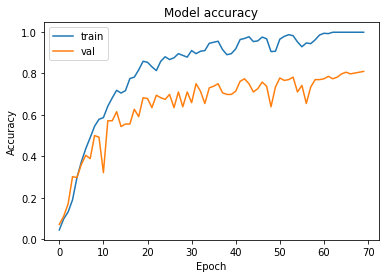

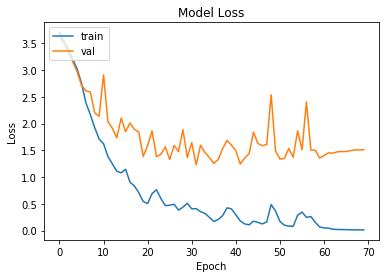

In [ ]:
visualize_accuracy(lenet_data_1)
visualize_loss(lenet_data_1)

### VGG16

In [ ]:
with strategy.scope():
  pretrained_model_1 = get_vgg16_model(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = num_classes_1)
  pretrained_model_1.compile(loss='categorical_crossentropy', 
                optimizer=optimizer_model_1, 
                metrics=['accuracy'])
pretrained_model_1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
pretrained_data_1 = pretrained_model_1.fit(tr_signs, tr_labels,
        batch_size=batch_size_model_1,
        epochs=25,
        verbose=2,
        validation_data=(va_signs, va_labels))

Train on 600 samples, validate on 252 samples
Epoch 1/25
600/600 - 18s - loss: 3.6121 - accuracy: 0.0550 - val_loss: 3.3113 - val_accuracy: 0.1310
Epoch 2/25
600/600 - 1s - loss: 3.0958 - accuracy: 0.2100 - val_loss: 2.7317 - val_accuracy: 0.2540
Epoch 3/25
600/600 - 1s - loss: 2.2063 - accuracy: 0.4000 - val_loss: 2.1338 - val_accuracy: 0.4683
Epoch 4/25
600/600 - 1s - loss: 1.4325 - accuracy: 0.6200 - val_loss: 1.3188 - val_accuracy: 0.6270
Epoch 5/25
600/600 - 1s - loss: 0.7897 - accuracy: 0.8267 - val_loss: 0.8549 - val_accuracy: 0.8056
Epoch 6/25
600/600 - 1s - loss: 0.4607 - accuracy: 0.9100 - val_loss: 0.5999 - val_accuracy: 0.8968
Epoch 7/25
600/600 - 1s - loss: 0.2768 - accuracy: 0.9583 - val_loss: 0.4813 - val_accuracy: 0.9048
Epoch 8/25
600/600 - 1s - loss: 0.1410 - accuracy: 0.9817 - val_loss: 0.4091 - val_accuracy: 0.9087
Epoch 9/25
600/600 - 1s - loss: 0.0764 - accuracy: 1.0000 - val_loss: 0.3770 - val_accuracy: 0.9087
Epoch 10/25
600/600 - 1s - loss: 0.0451 - accuracy: 1

In [ ]:
start = time()
loss, acc = pretrained_model_1.evaluate(te_signs, te_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

361/361 [==============================] - 1s 4ms/sample - loss: 0.2147 - accuracy: 0.9501
CNN took 2.640568971633911 seconds
Test loss: 0.21474333276709032 - Accuracy: 0.95013845


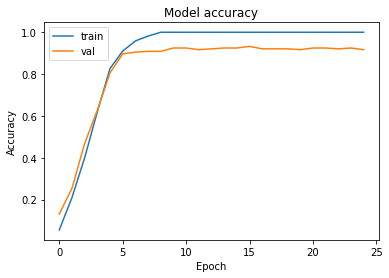

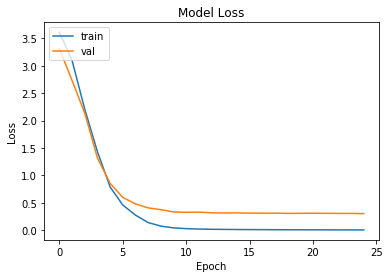

In [ ]:
visualize_accuracy(pretrained_data_1)
visualize_loss(pretrained_data_1)

### AlexNet

In [ ]:
with strategy.scope():
  alexnet_model_1 = get_alexnet_model(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = num_classes_1)
  alexnet_model_1.compile(loss='categorical_crossentropy', 
                optimizer=optimizer_model_1, 
                metrics=['accuracy'])
alexnet_model_1.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 214, 214, 64)      23296     
_________________________________________________________________
batch_normalization_77 (Batc (None, 214, 214, 64)      256       
_________________________________________________________________
activation_125 (Activation)  (None, 214, 214, 64)      0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 71, 71, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 65, 65, 128)       401536    
_________________________________________________________________
batch_normalization_78 (Batc (None, 65, 65, 128)       512       
_________________________________________________________________
activation_126 (Activation)  (None, 65, 65, 128)     

In [ ]:
alexnet_data_1 = alexnet_model_1.fit(tr_signs, tr_labels,
        batch_size=batch_size_model_1,
        epochs=800,
        verbose=2,
        validation_data=(va_signs, va_labels))

Train on 600 samples, validate on 252 samples
Epoch 1/800
600/600 - 5s - loss: 3.0571 - accuracy: 0.2333 - val_loss: 3.7281 - val_accuracy: 0.0794
Epoch 2/800
600/600 - 1s - loss: 2.9386 - accuracy: 0.2700 - val_loss: 3.6042 - val_accuracy: 0.1270
Epoch 3/800
600/600 - 1s - loss: 2.8629 - accuracy: 0.3300 - val_loss: 3.5326 - val_accuracy: 0.1270
Epoch 4/800
600/600 - 1s - loss: 2.8138 - accuracy: 0.3500 - val_loss: 3.5058 - val_accuracy: 0.1627
Epoch 5/800
600/600 - 1s - loss: 2.7592 - accuracy: 0.3700 - val_loss: 3.4386 - val_accuracy: 0.2103
Epoch 6/800
600/600 - 1s - loss: 2.7068 - accuracy: 0.3650 - val_loss: 3.3368 - val_accuracy: 0.2540
Epoch 7/800
600/600 - 1s - loss: 2.6343 - accuracy: 0.4083 - val_loss: 3.2818 - val_accuracy: 0.2460
Epoch 8/800
600/600 - 1s - loss: 2.6630 - accuracy: 0.3867 - val_loss: 3.2067 - val_accuracy: 0.2460
Epoch 9/800
600/600 - 1s - loss: 2.6054 - accuracy: 0.4167 - val_loss: 3.1275 - val_accuracy: 0.2817
Epoch 10/800
600/600 - 1s - loss: 2.5441 - ac

In [ ]:
start = time()
loss, acc = alexnet_model_1.evaluate(te_signs, te_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

361/361 [==============================] - 5s 13ms/sample - loss: 0.2014 - accuracy: 0.9557
CNN took 6.20286750793457 seconds
Test loss: 0.20141671298696062 - Accuracy: 0.95567864


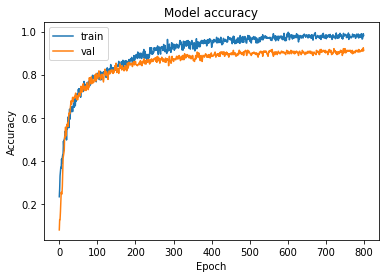

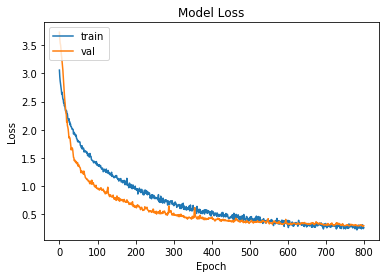

In [ ]:
visualize_accuracy(alexnet_data_1)
visualize_loss(alexnet_data_1)

### Evaluate model with preprocessing

#### Preprocessing GTSRB

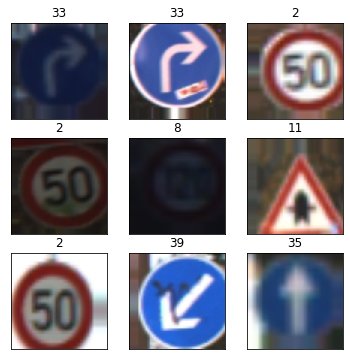

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

In [ ]:
model_1_preproc = get_alexnet_model(input_shape = (SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = num_classes_1)
model_1_preproc.compile(loss='categorical_crossentropy', 
              optimizer=optimizer_model_1, 
              metrics=['accuracy'])

In [ ]:
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data_1_preproc = model_1_preproc.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=10), 
                         epochs=epochs_model_2, 
                         steps_per_epoch=train_steps, 
                         verbose=2, 
                         validation_data=(va_signs, va_labels), 
                         validation_steps=valid_steps)

In [ ]:
start = time()
loss, acc = model_1_preproc.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

CNN took 4.600038051605225 seconds
Test loss: 1.9680385180127258 - Accuracy: 0.5096953


In [ ]:
visualize_accuracy(data_1_preproc)
visualize_loss(data_1_preproc)

# CIFAR 100 Dataset

In [ ]:
from keras.datasets import cifar100
(_x_train, _y_train), (_x_test, _y_test) = cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 2s 0us/step


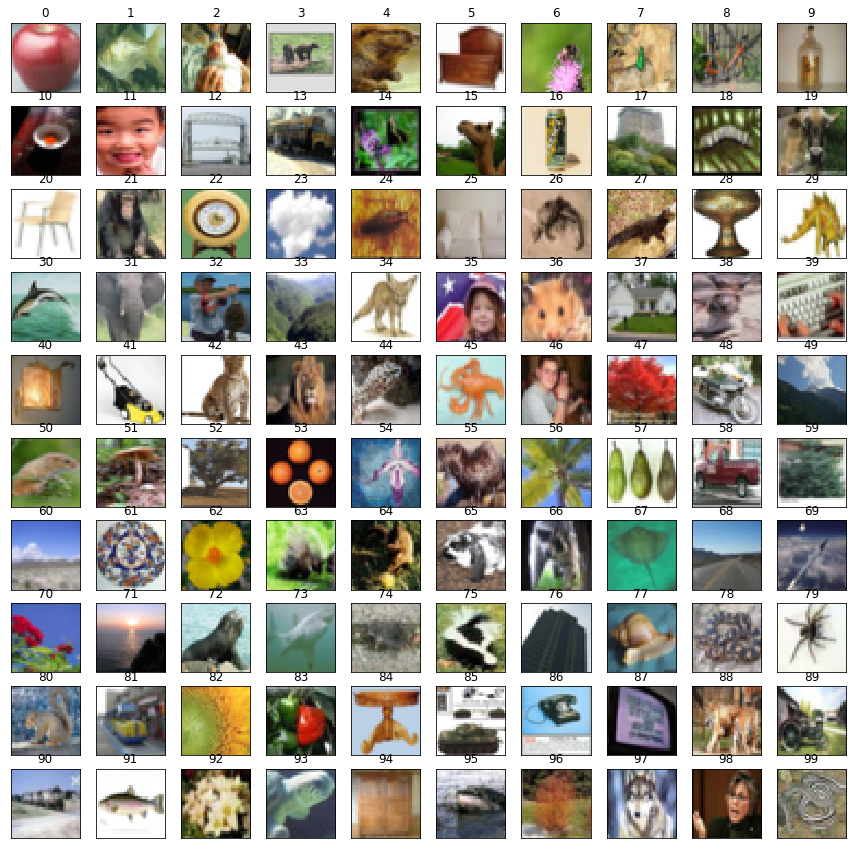

In [ ]:
# Show examples from each class
class_names = np.unique(_y_train)

fig, axes = plt.subplots(10, 10,figsize=(15, 15))
for i in range(num_classes_2):
    ax = axes.flatten()[i]
    indices = np.where(np.isin(_y_train, class_names[i]))[0]
    ax.imshow(_x_train[int(np.random.choice(indices, 1))])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(i)
plt.show()

In [ ]:
# Data pre-processing
cifar_val = _x_train[40000:]
cifar_label_val = _y_train[40000:]
cifar_train = _x_train[:40000]
cifar_label_train = _y_train[:40000]
cifar_test = _x_test
cifar_label_test = _y_test

# Normalize the images to be values in range [0, 1]
cifar_train = cifar_train.astype('float32')
cifar_val = cifar_val.astype('float32')
cifar_test = cifar_test.astype('float32')
cifar_train /= 255.0
cifar_val /= 255.0
cifar_test /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
cifar_tr_labels = np_utils.to_categorical(cifar_label_train, num_classes_2)
cifar_va_labels = np_utils.to_categorical(cifar_label_val, num_classes_2)
cifar_te_labels = np_utils.to_categorical(cifar_label_test, num_classes_2)

CIFAR_SIZE = (32, 32)

### SGD

In [ ]:
with strategy.scope():
  model_2 = get_model_2(input_shape=(CIFAR_SIZE[0], CIFAR_SIZE[1], 3), num_classes = num_classes_2)
  model_2.compile(loss='categorical_crossentropy', 
                optimizer=optimizer_model_1, 
                metrics=['accuracy'])
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_36 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
activation_37 (Activation)   (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 15, 15, 256)      

In [ ]:
data_2 = model_2.fit(cifar_train, 
                 cifar_tr_labels, 
                 batch_size=batch_size_model_2, 
                 epochs=epochs_model_2, 
                 verbose=2, 
                 validation_data=(cifar_val, cifar_va_labels))

Train on 40000 samples, validate on 10000 samples
Epoch 1/48
40000/40000 - 16s - loss: 4.5441 - accuracy: 0.0192 - val_loss: 4.3707 - val_accuracy: 0.0361
Epoch 2/48
40000/40000 - 8s - loss: 4.3202 - accuracy: 0.0435 - val_loss: 4.1422 - val_accuracy: 0.0799
Epoch 3/48
40000/40000 - 9s - loss: 4.1383 - accuracy: 0.0718 - val_loss: 3.9425 - val_accuracy: 0.1156
Epoch 4/48
40000/40000 - 8s - loss: 3.9637 - accuracy: 0.0981 - val_loss: 3.7538 - val_accuracy: 0.1528
Epoch 5/48
40000/40000 - 9s - loss: 3.8108 - accuracy: 0.1227 - val_loss: 3.6141 - val_accuracy: 0.1717
Epoch 6/48
40000/40000 - 8s - loss: 3.6964 - accuracy: 0.1412 - val_loss: 3.5324 - val_accuracy: 0.1875
Epoch 7/48
40000/40000 - 9s - loss: 3.6044 - accuracy: 0.1543 - val_loss: 3.4408 - val_accuracy: 0.1992
Epoch 8/48
40000/40000 - 9s - loss: 3.5221 - accuracy: 0.1694 - val_loss: 3.3665 - val_accuracy: 0.2095
Epoch 9/48
40000/40000 - 9s - loss: 3.4298 - accuracy: 0.1850 - val_loss: 3.3021 - val_accuracy: 0.2253
Epoch 10/48
4

In [ ]:
start = time()
loss, acc = model_2.evaluate(cifar_test, cifar_te_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

10000/10000 [==============================] - 6s 642us/sample - loss: 1.8855 - accuracy: 0.5085
CNN took 7.402865171432495 seconds
Test loss: 1.8854575302124024 - Accuracy: 0.5085


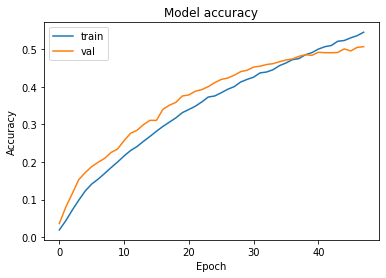

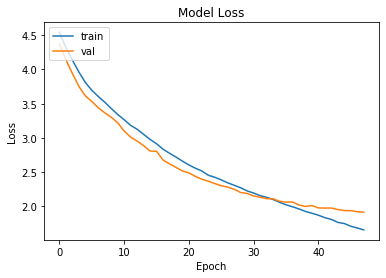

In [ ]:
visualize_accuracy(model_2.history)
visualize_loss(model_2.history)

### Adam

In [ ]:
with strategy.scope():
  model_2 = get_model_2(input_shape=(CIFAR_SIZE[0], CIFAR_SIZE[1], 3), num_classes = num_classes_2)
  model_2.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.Nadam(lr=0.00005), 
                metrics=['accuracy'])
model_2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_68 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 30, 30, 128)       147584    
_________________________________________________________________
activation_69 (Activation)   (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 15, 15, 256)     

In [ ]:
data_2 = model_2.fit(cifar_train, 
                 cifar_tr_labels, 
                 batch_size=batch_size_model_2, 
                 epochs=epochs_model_2, 
                 verbose=2, 
                 validation_data=(cifar_val, cifar_va_labels))

Train on 40000 samples, validate on 10000 samples
Epoch 1/48
40000/40000 - 13s - loss: 1.6045 - accuracy: 0.5568 - val_loss: 1.9636 - val_accuracy: 0.5011
Epoch 2/48
40000/40000 - 9s - loss: 1.5790 - accuracy: 0.5642 - val_loss: 1.9538 - val_accuracy: 0.5037
Epoch 3/48
40000/40000 - 9s - loss: 1.5453 - accuracy: 0.5688 - val_loss: 1.9610 - val_accuracy: 0.5059
Epoch 4/48
40000/40000 - 9s - loss: 1.5044 - accuracy: 0.5815 - val_loss: 1.9482 - val_accuracy: 0.5072
Epoch 5/48
40000/40000 - 9s - loss: 1.4833 - accuracy: 0.5846 - val_loss: 1.9412 - val_accuracy: 0.5089
Epoch 6/48
40000/40000 - 9s - loss: 1.4460 - accuracy: 0.5943 - val_loss: 1.9369 - val_accuracy: 0.5093
Epoch 7/48
40000/40000 - 9s - loss: 1.4019 - accuracy: 0.6030 - val_loss: 1.9690 - val_accuracy: 0.5077
Epoch 8/48
40000/40000 - 9s - loss: 1.3709 - accuracy: 0.6134 - val_loss: 1.9380 - val_accuracy: 0.5144
Epoch 9/48
40000/40000 - 9s - loss: 1.3468 - accuracy: 0.6168 - val_loss: 1.9389 - val_accuracy: 0.5132
Epoch 10/48
4

KeyboardInterrupt: ignored

In [ ]:
start = time()
loss, acc = model_2.evaluate(cifar_test, cifar_te_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

10000/10000 [==============================] - 5s 479us/sample - loss: 1.9779 - accuracy: 0.5196
CNN took 5.726747751235962 seconds
Test loss: 1.9778519897460938 - Accuracy: 0.5196


In [ ]:
visualize_accuracy(model_2.history)
visualize_loss(model_2.history)

### Preprocessing

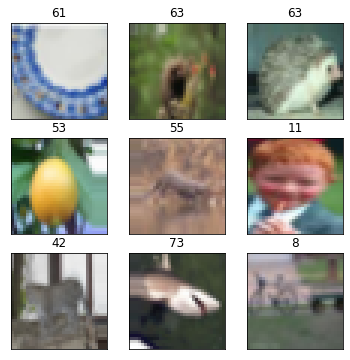

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, fill_mode='nearest')
datagen.fit(cifar_train, augment=True)

for x_batch, y_batch in datagen.flow(cifar_train, cifar_tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(x_batch[i])
    # show the plot
    plt.show()
    break

In [ ]:
model_2_preproc = get_model_2(input_shape= (CIFAR_SIZE[0], CIFAR_SIZE[1], 3), num_classes = num_classes_2)
model_2_preproc.compile(loss='categorical_crossentropy', 
              optimizer=optimizer_model_2, 
              metrics=['accuracy'])
model_2_preproc.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        23296     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       401536    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________

In [ ]:
train_steps = int(len(cifar_train) / 16)
valid_steps = int(len(cifar_val) / 16)
data_2_preproc = model_2_preproc.fit_generator(datagen.flow(cifar_train, cifar_tr_labels, batch_size=batch_size_model_2), 
                         epochs=epochs_model_2 * 2, 
                         steps_per_epoch=train_steps, 
                         verbose=2, 
                         validation_data=(cifar_val, cifar_va_labels), 
                         validation_steps=valid_steps)

start = time()
loss, acc = model_2_preproc.evaluate(cifar_test, cifar_te_labels, verbose=2)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Epoch 1/200
Epoch 1/200
10000/2500 - 69s - loss: 3.3891 - acc: 0.2098
2500/2500 - 3031s - loss: 3.4717 - acc: 0.1917 - val_loss: 3.3761 - val_acc: 0.2098
Epoch 2/200
Epoch 1/200
10000/2500 - 69s - loss: 3.2656 - acc: 0.2298
2500/2500 - 3019s - loss: 2.8328 - acc: 0.3106 - val_loss: 3.2816 - val_acc: 0.2298
Epoch 3/200


In [ ]:
visualize_accuracy(data_2_preproc)
visualize_loss(data_2_preproc)